<a href="https://colab.research.google.com/github/dajebbar/1.exploratory-data-analysis-MLR/blob/master/Hyperparameter_tuning_by_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Hyperparameter tuning by grid-search
---
Hyperparameter tuning by grid-search
In the previous notebook, we saw that hyperparameters can affect the generalization performance of a model. In this notebook, we will show how to optimize hyperparameters using a grid-search approach.

## predictive model

In [1]:
from sklearn import set_config

set_config(display="diagram")

In [2]:
import pandas as pd

adult_census = pd.read_csv("./adult.csv")

We extract the column containing the target.

In [3]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the "`education-num`" column which duplicates the information from the "`education`" column.

In [4]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Once the dataset is loaded, we split it into a training and testing sets.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    random_state=42)

We will define a pipeline and it will handle both numerical and categorical features.

As we will use a tree-based model as a predictor, here we apply an ordinal encoder on the categorical features: it encodes every category with an arbitrary integer. For simple models such as linear models, a one-hot encoder should be preferred. But for complex models, in particular tree-based models, the ordinal encoder is useful as it avoids having high-dimensional representations.

First we select all the categorical columns.

In [6]:
from sklearn.compose import make_column_selector as selector

categorical_columns = selector(dtype_include=object)(data)

Then we build our ordinal encoder, giving it the known categories.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

We now use a column transformer with code to select the categorical columns and apply to them the ordinal encoder.

In [8]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

inally, we use a tree-based classifier (i.e. histogram gradient-boosting) to predict whether or not a person earns more than 50 k$ a year.

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a grid-search
Instead of manually writing the two `for` loops, scikit-learn provides a class called `GridSearchCV` which implement the exhaustive search implemented during the exercise.

Let see how to use the `GridSearchCV` estimator for doing such search. Since the grid-search will be costly, we will only explore the combination `learning-rate` and the `maximum number of nodes`.



In [10]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': [0.001, 0.01, 0.03, 0.1, 1, 10],
    'classifier__max_leaf_nodes': [2, 4, 10, 20, 50, 100]
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=4, cv=10)

CPU times: user 97 µs, sys: 0 ns, total: 97 µs
Wall time: 103 µs


Finally, we will check the accuracy of our model using the test set.

In [12]:
model_grid_search.fit(X_train, y_train)
accuracy = model_grid_search.score(X_test, y_test)

print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


### Warning

Be aware that the evaluation should normally be performed in a cross-validation framework by providing model_grid_search as a model to the cross_validate function.

Here, we are using a single train-test split to highlight the specificities of the model_grid_search instance.

The `GridSearchCV` estimator takes a `param_grid` parameter which defines all hyperparameters and their associated values. The grid-search will be in charge of creating all possible combinations and test them.

The number of combinations will be equal to the product of the number of values to explore for each parameter (e.g. in our example 6 x 6 combinations). Thus, adding new parameters with their associated values to be explored become rapidly computationally expensive.

Once the grid-search is fitted, it can be used as any other predictor by calling `predict` and `predict_proba`. Internally, it will use the model with the best parameters found during `fit`.

Get predictions for the 5 first samples using the estimator with the best parameters.

In [13]:
model_grid_search.predict(X_test.iloc[:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [14]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 20}


we can inspect all results which are stored in the attribute `cv_results_`
 of the grid-search. We will filter some specific columns from these results.

In [15]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    by='mean_test_score', ascending=False
)

cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
21,3.301159,0.059939,0.174944,0.009298,0.1,20,"{'classifier__learning_rate': 0.1, 'classifier...",0.876638,0.862954,0.868687,0.879061,0.872236,0.873328,0.870052,0.868414,0.870598,0.868960,0.871093,0.004308,1
22,4.047359,0.262163,0.173550,0.012051,0.1,50,"{'classifier__learning_rate': 0.1, 'classifier...",0.878002,0.858313,0.868960,0.875785,0.870871,0.871417,0.869506,0.870325,0.868414,0.870871,0.870246,0.004909,2
20,2.667980,0.069736,0.153256,0.031244,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.869814,0.862408,0.868960,0.877150,0.870052,0.870325,0.867868,0.866503,0.870871,0.869233,0.869318,0.003514,3
23,5.282613,0.429728,0.173044,0.009176,0.1,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.875819,0.864046,0.866503,0.873328,0.866230,0.871417,0.870325,0.865138,0.868687,0.867049,0.868854,0.003604,4
17,7.917051,0.562295,0.235949,0.036695,0.03,100,"{'classifier__learning_rate': 0.03, 'classifie...",0.871179,0.861862,0.865138,0.873874,0.868414,0.872509,0.865957,0.866503,0.870052,0.870871,0.868636,0.003547,5


Let us focus on the most interesting columns and shorten the parameter names to remove the "`param_classifier__`" prefix for readability:

In [16]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [17]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
21,0.1,20,0.871093,0.004308,1
22,0.1,50,0.870246,0.004909,2
20,0.1,10,0.869318,0.003514,3
23,0.1,100,0.868854,0.003604,4
17,0.03,100,0.868636,0.003547,5
16,0.03,50,0.868254,0.004740,6
25,1,4,0.864159,0.004427,7
24,1,2,0.863804,0.004183,8
15,0.03,20,0.863012,0.004167,9
26,1,10,0.862439,0.004008,10


With only 2 parameters, we might want to visualize the grid-search as a heatmap. We need to transform our cv_results into a dataframe where:

- the rows will correspond to the learning-rate values;
- the columns will correspond to the maximum number of leaf;
- the content of the dataframe will be the mean test scores.

In [18]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,2,4,10,20,50,100
learning_rate,,,,,,
0.001,0.758947,0.758947,0.758947,0.758947,0.758947,0.758947
0.010,0.787830,0.797248,0.818214,0.842811,0.850291,0.851847
0.030,0.799650,0.823674,0.855860,0.863012,0.868254,0.868636
0.100,0.824602,0.860228,0.869318,0.871093,0.870246,0.868854
1.000,0.863804,0.864159,0.862439,0.860282,0.851410,0.844558
10.000,0.283476,0.283476,0.770085,0.292840,0.673728,0.727062


We can use a heatmap representation to show the above dataframe visually.

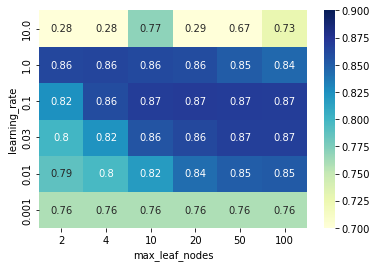

In [19]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The above tables highlights the following things:

for too high values of learning_rate, the generalization performance of the model is degraded and adjusting the value of max_leaf_nodes cannot fix that problem;
outside of this pathological region, we observe that the optimal choice of max_leaf_nodes depends on the value of learning_rate;
in particular, we observe a "diagonal" of good models with an accuracy close to the maximal of 0.87: when the value of max_leaf_nodes is increased, one should decrease the value of learning_rate accordingly to preserve a good accuracy.

For now we will note that, in general, there is no unique optimal parameter setting: 6 models out of the 36 parameter configurations reach the maximal accuracy (up to small random fluctuations caused by the sampling of the training set).